# Simulation of Axonal Guidance

We simulate axon guidance to demonstrate that axons can use our proposed mechanism to navigate through the gene expression address space discovered in the [Hierarchy Decomposition notebook](./Hierarchy%20Decomposition.ipynb).

In [1]:
%load_ext autoreload
%autoreload 2

from guidance_experiment import SimulatedExperiment, DataExperiment
from guidance_plots import (distance_vs_path_length_plot,
                                    plot_reached_voxel_count_comparison,
                                    plot_path_length_comparison,
                                    plot_reached_distance_comparison,
                                    plot_correlation_distribution)
from abianalysis.volume.volume import VOXEL_SIZES
import numpy as np
import json
from tqdm import tqdm
from abianalysis import get_euclidean_distance

import pandas as pd

from scipy.spatial.distance import pdist, squareform, cdist

import igraph
from abianalysis.tree.traverse import traverse_depth_first

import matplotlib.pyplot as plt

In [2]:
global_params = dict(
    age='P28',
    n_iterations=32,
    n_sources=1000,
    landscape_threshold=.1,
    gradient_threshold=.0,
    split_method='pca'
)

In [4]:
experimental = DataExperiment(**global_params,
                         label='Experimental')
experimental.prepare()
experimental.sample_axons()
axon_sources = [experimental.guidance_graph.get_voxel_index(v) 
                for v in experimental.sources]
random_axons = list(experimental.random_fake_axons())

Preparing volume...
Preparing voxel graph...
Preparing hierarchy...


Sampling axons: 100%|███████████████████████| 1000/1000 [03:46<00:00,  4.41it/s]


In [7]:
noise10 = DataExperiment(**global_params, label='Noise10', noise_amount=.1)
noise10.prepare()
noise10.sample_axons(axon_sources)

Preparing volume...
Preparing voxel graph...
Preparing hierarchy...


Sampling axons: 100%|███████████████████████| 1000/1000 [03:40<00:00,  4.53it/s]


In [8]:
noise100 = DataExperiment(**global_params, label='Noise100', noise_amount=1.)
noise100.prepare()
noise100.sample_axons(axon_sources)

Preparing volume...
Preparing voxel graph...
Preparing hierarchy...


Sampling axons: 100%|███████████████████████| 1000/1000 [00:14<00:00, 69.68it/s]


In [9]:
noise30 = DataExperiment(**global_params, label='Noise30', noise_amount=.3)
noise30.prepare()
noise30.sample_axons(axon_sources)

Preparing volume...
Preparing voxel graph...
Preparing hierarchy...


Sampling axons: 100%|███████████████████████| 1000/1000 [03:50<00:00,  4.33it/s]


In [10]:
n_few_genes=100
few_genes = DataExperiment(**global_params,
                           label='Few genes',
                           genes=np.random.choice(2027, size=n_few_genes, replace=False))
few_genes.prepare()
few_genes.sample_axons(axon_sources)

Preparing volume...
Preparing voxel graph...
Preparing hierarchy...


Sampling axons: 100%|███████████████████████| 1000/1000 [08:19<00:00,  2.00it/s]


In [11]:
def dissimilarity_scores(ex1, ex2, axons=None):
    if axons is None:
        axons = ex2.axons
    ex1_pos = ex1.volume.voxel_indices
    ex2_pos = ex2.volume.voxel_indices
    ss = []
    for (_, e1), (_, e2) in zip(sorted((a.source_voxel, a) for a in ex1.axons), 
                                sorted((a.source_voxel, a) for a in axons)):
        d = cdist(ex1_pos[e1.tips], ex2_pos[e2.tips])
        m = (np.mean(np.min(d, 0)) + np.mean(np.min(d, 1))) / 2
        s = np.mean(m) / 5
        ss.append(s)
    return ss

In [12]:
exp_n10 = dissimilarity_scores(experimental, noise10)
exp_n30 = dissimilarity_scores(experimental, noise30)
exp_n100 = dissimilarity_scores(experimental, noise100)
exp_fg = dissimilarity_scores(experimental, few_genes)
exp_rnd = dissimilarity_scores(experimental, experimental, axons=random_axons)

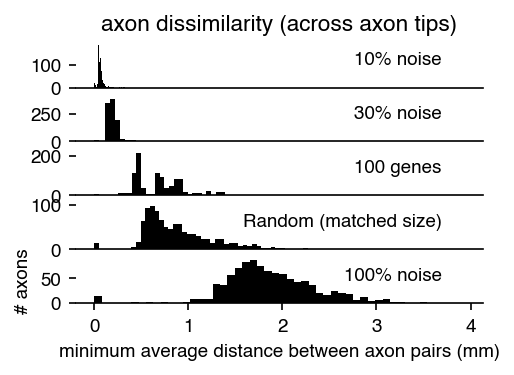

In [13]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 9}
import matplotlib
matplotlib.rc('font', **font)

fig, axs = plt.subplots(nrows=5, sharex=True, dpi=150, figsize=(3.5, 2.3))

def plot_hist(ax, exp, label=None):
    ax.hist(exp, bins=50, color='k')
    ax.grid(False)
    ax.label_outer()
    ax.spines['bottom'].set_visible(True)
    plt.setp(ax.xaxis.get_major_ticks(), visible=False)
    if label is not None:
        ax.text(.9, .8, label, transform=ax.transAxes, ha='right', va='top')
    return ax

axs[0].set_title('axon dissimilarity (across axon tips)')

  
plot_hist(axs[0], exp_n10, label='10% noise')
plot_hist(axs[1], exp_n30, label='30% noise')
plot_hist(axs[2], exp_fg, label=f'{n_few_genes} genes')
plot_hist(axs[3], exp_rnd, label='Random (matched size)')
plot_hist(axs[4], exp_n100, label='100% noise')
plt.setp(axs[4].xaxis.get_major_ticks(), visible=True)
axs[4].set_ylabel('# axons')
axs[4].set_xlabel('minimum average distance between axon pairs (mm)')
fig.savefig('expanded_robustness.pdf', transparent=True)

Calculating path distances: 100%|███████████| 1000/1000 [05:02<00:00,  3.30it/s]
/var/folders/7_/632gsjmd1hx6lz5p076wm5_c0000gn/T/ipykernel_80192/3591093876.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


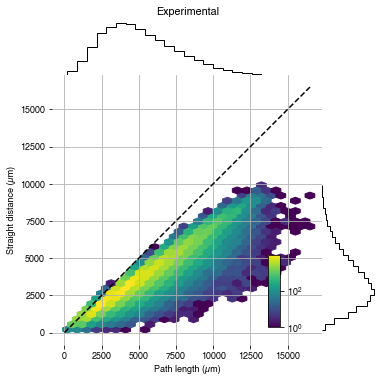

In [14]:
fig = distance_vs_path_length_plot(experimental, n_bins=25)
fig.tight_layout()
fig.savefig('sim_axons_regular_p28.pdf')

Calculating path distances: 100%|████████| 1000/1000 [00:00<00:00, 15657.75it/s]
/var/folders/7_/632gsjmd1hx6lz5p076wm5_c0000gn/T/ipykernel_80192/1076027092.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


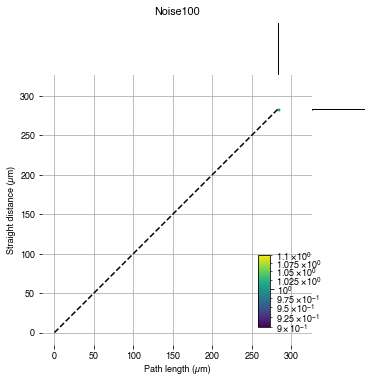

In [15]:
fig = distance_vs_path_length_plot(noise100, n_bins=25)
fig.tight_layout()
fig.savefig('sim_axons_regular_p28.pdf')

Calculating path distances: 100%|███████████| 1000/1000 [30:38<00:00,  1.84s/it]
/var/folders/7_/632gsjmd1hx6lz5p076wm5_c0000gn/T/ipykernel_80192/3675581751.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


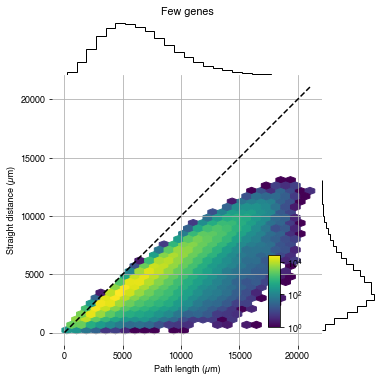

In [16]:
fig = distance_vs_path_length_plot(few_genes, n_bins=25)
fig.tight_layout()
fig.savefig('sim_axons_few_genes_p28.pdf')

In [20]:
shuffled = DataExperiment(**global_params,
                          expression='shuffled',
                          label='Shuffled')
shuffled.prepare()
shuffled.sample_axons(axon_sources)

Preparing volume...
Preparing voxel graph...
Preparing hierarchy...



Making guidance graph: 100%|████████████████████| 63/63 [00:11<00:00,  5.67it/s]

Sampling axons:  23%|█████▌                  | 232/1000 [00:03<00:10, 70.36it/s]


Sampling axons:  98%|███████████████████████▌| 983/1000 [00:14<00:00, 66.97it/s]


Sampling axons: 100%|███████████████████████| 1000/1000 [00:14<00:00, 69.23it/s]



Calculating path lengths: 100%|██████████| 1000/1000 [00:00<00:00, 13960.03it/s]

Calculating path distances: 100%|████████| 1000/1000 [00:00<00:00, 14531.87it/s]
/var/folders/7_/632gsjmd1hx6lz5p076wm5_c0000gn/T/ipykernel_80192/1865379843.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


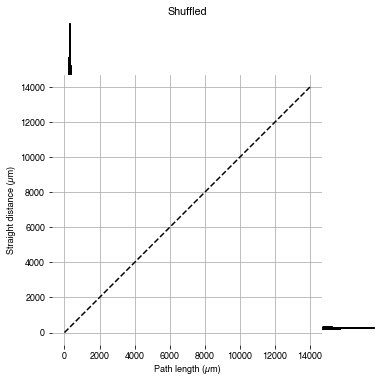

In [21]:
fig = distance_vs_path_length_plot(shuffled, n_bins=25, max_value=14000, colorbar=False)
fig.tight_layout()
fig.savefig('sim_axons_shuffled_p28.pdf')

In [6]:
simulated = SimulatedExperiment(**global_params,
                                n_voxels=experimental.volume.n_voxels,
                                label='Simulated')
simulated.prepare()
simulated.sample_axons()
# simulated.save_to_json()

Simulating volume...
Preparing voxel graph...
Preparing hierarchy...


Sampling axons: 100%|███████████████████████| 1000/1000 [00:57<00:00, 17.33it/s]


Calculating path distances: 100%|███████████| 1000/1000 [00:51<00:00, 19.40it/s]
/var/folders/7_/632gsjmd1hx6lz5p076wm5_c0000gn/T/ipykernel_83462/250893111.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


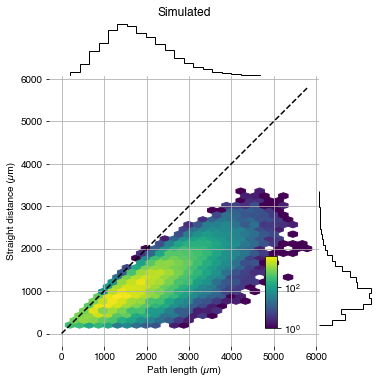

In [7]:
fig = distance_vs_path_length_plot(simulated, n_bins=25)
fig.tight_layout()
fig.savefig('sim_axons_simulated_p28.pdf')

In [8]:
label_anatomies = [experimental.volume.anatomy[0].root.find(name) for name in [
    'dorsal pallium/isocortex',  # Isocortex
    'ventral pallium',  # Olfactory bulb
    'medial pallium (hippocampal allocortex)',  # Hippocampal formation
    'striatum (corpus striatum)',  # Striatum
    'pallidum (globus pallidus complex)',  # Pallidum
    'thalamus',  # Thalamus
    'peduncular (caudal) hypothalamus',  # Hypothalamus
    'rostral secondary prosencephalon',  # Hypothalamus
    'midbrain',  # Midbrain
    'pontine hindbrain',  # Pons
    'medullary hindbrain (medulla)',  # medulla
    'cerebellar vermis',  # Cerebellum
]]

In [9]:
def sort_voxels(voxels, roots=None):
    if roots is None:
        roots = [experimental.volume.anatomy[0].root]
        
    idx = {}
    i = 0
    for root in roots:
        for a in traverse_depth_first(root):
            if a not in idx:
                idx[a] = i
                i += 1
                
    anatomies = experimental.volume.anatomy[voxels]
    idx_list = np.array([idx[a] if a in idx else np.nan for a in anatomies])    
    s = np.argsort(idx_list)
    return voxels[s[~np.isnan(idx_list[s])]]


def get_sources_and_tips(axons):
    tips = np.array(list(set(tip for axon in axons for tip in axon.tips)))
    srcs = np.array(list(set([axon.source_voxel for axon in axons])))
    
    assert len(axons) == len(srcs), (
        'the number of sources must be the number of ' 
         'axons. Otherwise, at least one axon is sampled twice.')
    
    return srcs, tips

def get_matrix(axons, src, tips):
    source_idx = {s: i for i, s in enumerate(src)}
    tip_idx = {t: i for i, t in enumerate(tips)}

    matrix = np.zeros((len(src), len(tips)))
    for axon in axons:
        if axon.source_voxel in source_idx:
            i = source_idx[axon.source_voxel]
            for tip in axon.tips:
                if tip in tip_idx:
                    j = tip_idx[tip]
                    matrix[i, j] = 1
    return matrix

def ticks_and_labels(anatomies, label_anatomies):
    
    label_sets = [(frozenset(a.descendants()), a.name) 
                  for a in label_anatomies]
    
    labels = []
    for anatomy in anatomies:
        for s, label in label_sets:
            if anatomy in s:
                labels.append(label)    
                break
    labels = np.array(labels)
    
    ticks = [0, *np.nonzero(np.diff([hash(l) for l in labels]))[0] + 1]

    return ticks, labels[ticks]



In [10]:
all_sources, all_tips = get_sources_and_tips(experimental.axons)
all_sources = sort_voxels(all_sources, roots=label_anatomies)
all_tips = sort_voxels(all_tips, roots=label_anatomies)
matrix = get_matrix(experimental.axons, all_sources, all_tips)

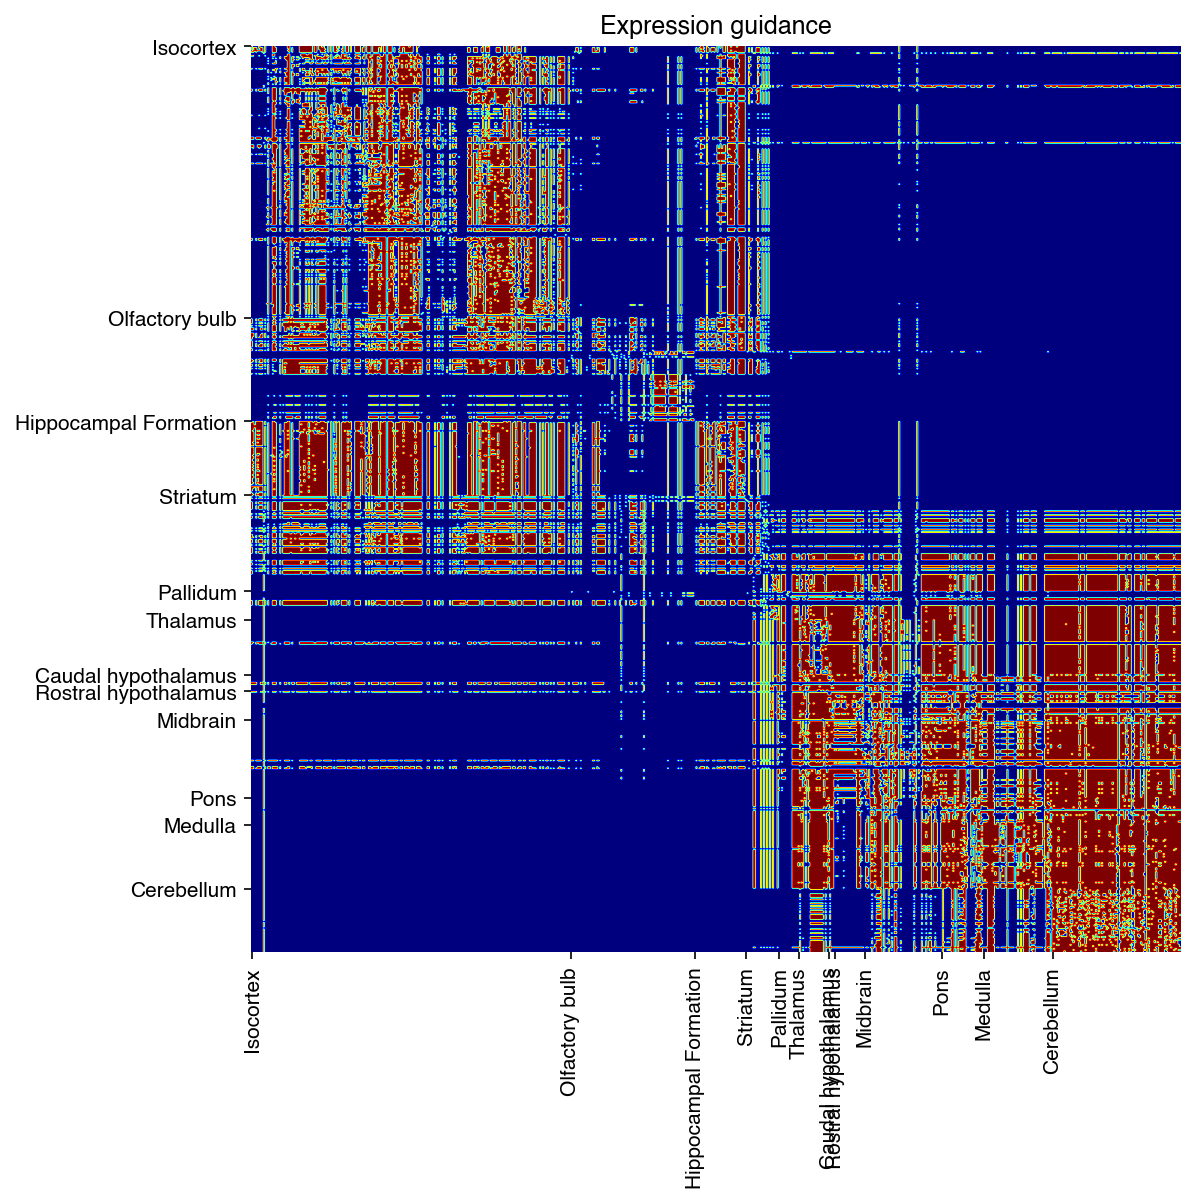

In [27]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=150)

cmap = 'jet'
interpolation = 'gaussian'

x_ticks, x_labels = ticks_and_labels(
    experimental.volume.anatomy[all_tips],
    label_anatomies)

y_ticks, y_labels = ticks_and_labels(
    experimental.volume.anatomy[all_sources], 
    label_anatomies)

labels = ['Isocortex', 'Olfactory bulb', 'Hippocampal Formation',
          'Striatum', 'Pallidum', 'Thalamus', 'Caudal hypothalamus',
          'Rostral hypothalamus', 'Midbrain', 'Pons', 'Medulla',
          'Cerebellum'
         ]

ax.set_title('Expression guidance')
ax.imshow(matrix , 
          interpolation=interpolation, 
          cmap=cmap)
ax.set_aspect('auto')
ax.set_xticks(x_ticks)
ax.set_xticklabels(labels, rotation=90)
ax.set_yticks(y_ticks)
ax.set_yticklabels(labels)
ax.grid()

fig.savefig('sim_axons_matrix.pdf')